<a href="https://colab.research.google.com/github/atripathy86/MD/blob/main/notebook_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook shows how to read in the existing images and corresponding ground truths (masks) from trajectories of *ab initio* molecular dynamics simulations performed on MoS2 with S defects.

## Here, one defect strucure is used as an example and corresponding energies are extracted to find the most energetically stable structure out of all the AIMD trajectories.

### Notebook prepared by Ayana Ghosh

Email: research.aghosh@gmail.com

## Option I: Thoughts for active learning target from the energies of individual trajectories



1.   Extract energy for every 10th iteration of a defect structure from simulation trajectories

2.   Find energy difference between the above and pristine structure

3.   Locate the structure that has the lowest energy along the trajectory, i.e. energetically most stable out of them

Install package

In [ ]:
!pip install atomai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174960 sha256=043d822f740fee9bd93afe9e55c1f39a45121486be79c41920d65390f881e40c
  Stored in directory: /root/.cache/pip/wheels/58/dc/35/3fa57a6ef1956eb96f1c261442ccb8a0f34a7f9d7403d82c96
Successfully built mendeleev


Import essential libraries

In [ ]:
import numpy as np
import os, re
import sys
import pandas as pd
import matplotlib.pyplot as plt
import atomai as aoi
np.random.seed(0)

In [ ]:
!gdown https://drive.google.com/uc?id=1-5WSDhJaVtNacj9McUL9a6ED3tCpyEUD
!gdown https://drive.google.com/uc?id=1-1Ap_eTA71pp7pugKuAzFdjU9vRToFMh

Downloading...
From: https://drive.google.com/uc?id=1-5WSDhJaVtNacj9McUL9a6ED3tCpyEUD
To: /content/cropped_masks_one_struct.npy
100% 136M/136M [00:00<00:00, 216MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1Ap_eTA71pp7pugKuAzFdjU9vRToFMh
To: /content/cropped_images_one_struct.npy
100% 67.8M/67.8M [00:00<00:00, 87.6MB/s]


In [ ]:
img_test = np.load('/content/cropped_images_one_struct.npy')
mask_test = np.load('/content/cropped_masks_one_struct.npy')

(-0.5, 207.5, 207.5, -0.5)

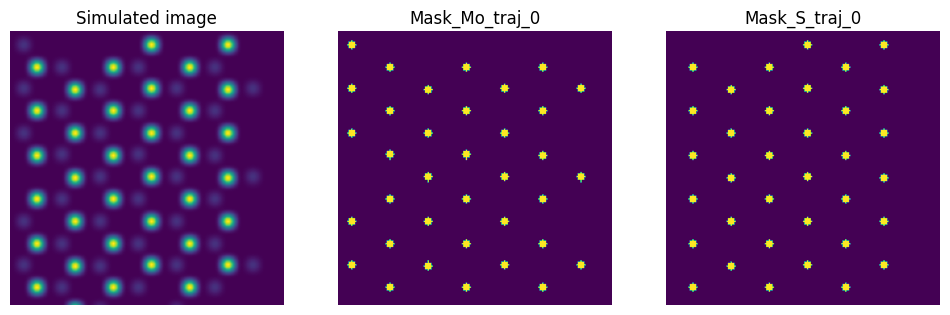

In [ ]:
#visualize the data

traj_id = 0
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.imshow(img_test[traj_id,:,:])
ax2.imshow(mask_test[traj_id,:,:,0])
ax3.imshow(mask_test[traj_id,:,:,1])
ax1.set_title("Simulated image")
ax2.set_title("Mask_Mo_traj_" + str(traj_id))
ax3.set_title("Mask_S_traj_" + str(traj_id))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

In [ ]:
#augmentation as necessary
dt = aoi.transforms.datatransform(1, # number of classes
                                  gauss_noise=[1000, 2000], # scaled values
                                  poisson_noise=[30, 45],
                                  blur=False,
                                  contrast=True,
                                  zoom=True,
                                  resize=[2, 1], # downsize all the images by a factor of 2
                                  seed=1)

X_train, y_train = dt.run(img_test, mask_test[..., None])

(-0.5, 207.5, 207.5, -0.5)

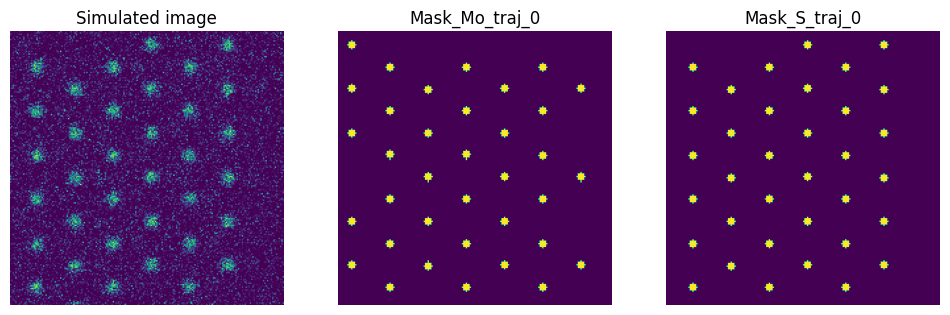

In [ ]:
#visualize the augmented data

traj_id = 0
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.imshow(X_train[traj_id,0])
ax2.imshow(y_train[traj_id,:,:,0])
ax3.imshow(y_train[traj_id,:,:,1])
ax1.set_title("Simulated image")
ax2.set_title("Mask_Mo_traj_" + str(traj_id))
ax3.set_title("Mask_S_traj_" + str(traj_id))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

## Extracting target for active learning

In [ ]:
#read in energy data from simulations
!gdown https://drive.google.com/uc?id=1--k5tirk-x6fMMTyCMF05GhRkJg-CIg9
energy_data = pd.read_csv('/content/energy_data.csv')

Downloading...
From: https://drive.google.com/uc?id=1--k5tirk-x6fMMTyCMF05GhRkJg-CIg9
To: /content/energy_data.csv
100% 12.3k/12.3k [00:00<00:00, 25.6MB/s]


In [ ]:
energy_data.columns

Index(['Unnamed: 0', 'Iteration', 'Energy', 'Temperature', 'Reference_Energy',
       'target_energy'],
      dtype='object')

### Target energy is computed by subtracting the energy corresonding to specific iteration of the defect structure from the energy of the pristine structure

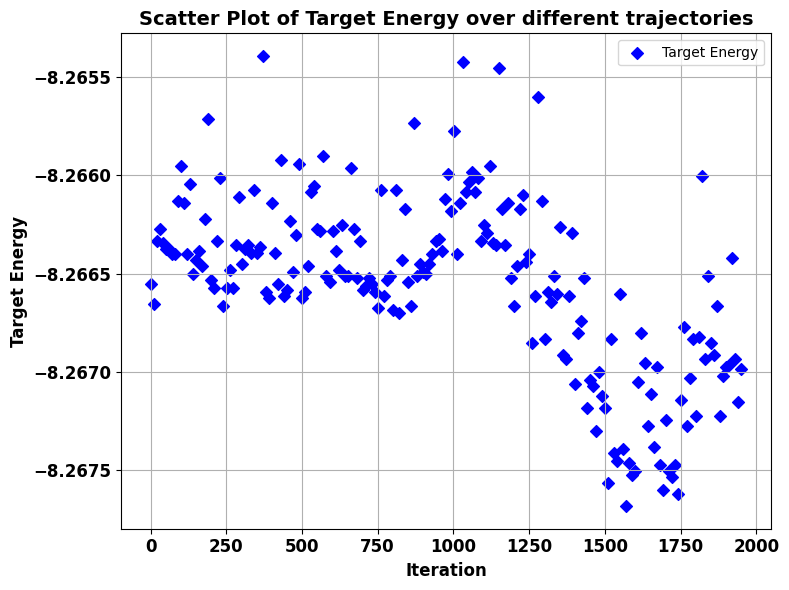

In [ ]:
# Plotting the scatter plot
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(energy_data['Iteration'], energy_data['target_energy'], label='Target Energy', color='blue', marker='D')

# Adding labels and title with font settings
plt.xlabel('Iteration', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.ylabel('Target Energy', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Scatter Plot of Target Energy over different trajectories', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.legend()

# Displaying the plot with grid
plt.grid(True)
plt.tight_layout()
plt.show()

## Active learning can find which iteration gives the energetically favorable structure. This information can be used to minimize the number of iterations for the AIMD simulations to bridge timescale during experiment.